# 3d Point Cloud GPU based loading and Manipulation with Nvidia Rapids

## Section 1 - Downloading Image
<br>

In [5]:
# create home for data to live
DATA_DIR="/home/jovyan/data/"

In [6]:
%%sh -s "$DATA_DIR"

[ ! -d "$1" ] && mkdir -p "$1"

In [7]:
import urllib.request
import shutil
import py7zr
import os
import glob

# Download the test file and save it locally under data directory if not already saved
file_name = DATA_DIR + 'bildstein_station1.7z'
url = 'http://semantic3d.net/data/point-clouds/training1/bildstein_station1_xyz_intensity_rgb.7z'
if not os.path.exists(file_name[:-3]):
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

    with py7zr.SevenZipFile(file_name, mode='r') as z:
        z.extractall(path=file_name[:-3])

In [8]:
for file in glob.glob(file_name[:-3] + "/" + "*.txt"):
    print(file)

/home/jovyan/data/bildstein_station1/bildstein_station1_xyz_intensity_rgb.txt


In [9]:
# open first line and see what we have
with open(file) as f:
    first_line = f.readline()
    names = "x, y, z, intensity, r, g, b"
    print(names)
    print("-" * 40)
    print(", ".join([ls for ls in first_line.split()]))
    names = names.split(', ')

x, y, z, intensity, r, g, b
----------------------------------------
20.623, 40.276, -1.999, -1031, 127, 141, 154


## Section 2 - Cudf for Fast Data Loading
<br>

In [10]:
import cudf
import cuspatial
import time

from urllib.request import urlopen

In [11]:
t0 = time.time()
df = cudf.io.csv.read_csv(file, delim_whitespace=True, names=names)
t1 = time.time()
print("start vs stop time: ", t1 - t0, " s")

start vs stop time:  0.48637866973876953  s


In [12]:
display(df.head()); print(df.shape)

,x,y,z,intensity,r,g,b
0,20.623,40.276,-1.999,-1031,127,141,154
1,20.362,40.375,-2.239,-941,130,141,159
2,20.360,40.376,-2.402,-1083,139,151,165
3,20.374,40.367,-2.405,-1122,131,147,163
4,20.372,40.366,-2.405,-1165,132,145,161


(29697591, 7)


In [13]:
print(df.memory_usage(deep=True).sum() / 10**6, " Mb")

1663.065096  Mb


In [10]:
df.describe()

,x,y,z,intensity,r,g,b
count,2.969759e+07,2.969759e+07,2.969759e+07,2.969759e+07,2.969759e+07,2.969759e+07,2.969759e+07
mean,1.354600e+00,1.754048e+00,-4.769280e-01,-1.112637e+03,1.021257e+02,1.036519e+02,1.019477e+02
std,1.078662e+01,1.071130e+01,3.127362e+00,3.870843e+02,4.395839e+01,4.581980e+01,4.705387e+01
min,-1.047000e+02,-1.335270e+02,-1.710900e+01,-1.766000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,-1.785000e+00,-2.034000e+00,-1.855000e+00,-1.365000e+03,7.200000e+01,7.100000e+01,7.000000e+01
50%,2.390000e-01,-6.350000e-01,-1.401000e+00,-1.199000e+03,1.040000e+02,1.050000e+02,9.800000e+01
75%,2.773000e+00,3.338000e+00,4.640000e-01,-1.062000e+03,1.290000e+02,1.310000e+02,1.280000e+02
max,1.205780e+02,1.128580e+02,4.737200e+01,2.043000e+03,2.550000e+02,2.550000e+02,2.550000e+02


In [11]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 29697591 entries, 0 to 29697590
Data columns (total 7 columns):
 #   Column     Dtype
---  ------     -----
 0   x          float64
 1   y          float64
 2   z          float64
 3   intensity  int64
 4   r          int64
 5   g          int64
 6   b          int64
dtypes: float64(3), int64(4)
memory usage: 1.5 GB


## Section 3 - Basic Plotting
<br>

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

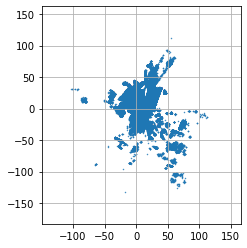

In [13]:
## calculate extents
eps = 1e-6
max_x = df['x'].max() + eps
min_x = df['x'].min() - eps
max_y = df['y'].max() + eps
min_y = df['y'].min() - eps

fig = plt.figure()
ax = fig.add_subplot(111)
w, h = max_x - min_x, max_y - min_y

# splits rectangle into squares and creates an array of those squares
sq_size = 50 # m sides
n_x = math.ceil(math.ceil((w) / sq_size) / 2.0) + 1
n_y = math.ceil(math.ceil((h) / sq_size) / 2.0) + 1
xs = np.arange(-n_x * sq_size, (n_x + 1) * sq_size, sq_size)
ys = np.arange(-n_y * sq_size, (n_y + 1) * sq_size, sq_size)
ax.set_xticks(xs)
ax.set_yticks(ys)
plt.grid()

# plot a sample of the points
tmp = df.sample(1000000)
plt.scatter(tmp['x'].to_array(), tmp['y'].to_array(), .2)
ax.set_xlim(min_x - 0.2 * w, max_x + 0.2 * w)
ax.set_ylim(min_y - 0.2 * h, max_y + 0.2 * h)
ax.set_aspect(1)

## Section 4 - DF manipulation
<br>
Let's say we wanted to break out the original dataframe into multiple dataframes representing 50 x 50 (h x w) vertical square columns containing points? We can create a list of bounding boxes based on the grid drawn above. To do this convert the x/y tick arrays to tuples of the form:

(x_min, x_max, y_min, y_max)

In [14]:
bboxes = \
    [tuple(xs[i:i+2].astype(float)) + tuple(ys[j:j+2].astype(float)) for i in range(xs.size - 1) for j in range(ys.size - 1)]

In [15]:
bboxes[0]

(-200.0, -150.0, -200.0, -150.0)

Nvidia rapid's CuSpatial library provides a function to collect the points in a spatial window, providing a fast look-up for x,y coordinates based on a bounding box

In [16]:
dfs = [cuspatial.points_in_spatial_window(*bbox, df['x'], df['y']) for bbox in bboxes]

In [18]:
dfs[21].head()

,x,y
0,-78.426,58.820
1,-79.537,58.785


This works but some dataframes are empty and all only contain x, y coordinates and no mapping back to the original df record. First, get a count of the points in each dataframe.

Text(0.5, 0, 'list index for list of bboxes')

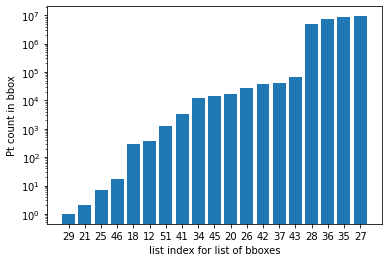

In [19]:
num_pts = [df.shape[0] for df in dfs]
ct_data = [(ix, pt_ct) for (ix, pt_ct) in enumerate(num_pts) if pt_ct > 0]
sorted_ct_data = sorted(ct_data, key = lambda x: x[1])
bbox_ix = list(zip(*sorted_ct_data))[0]
pt_ct = list(zip(*sorted_ct_data))[1]
x_pos = np.arange(len(bbox_ix))

plt.bar(x_pos, pt_ct, align='center')
plt.xticks(x_pos, bbox_ix)
plt.yscale('log')
plt.ylabel('Pt count in bbox')
plt.xlabel('list index for list of bboxes')

Next, calculate the masks to bin all the points in their respective dataframes. This function uses the point in polygon function to calculate which points belong in a list of polygons. This is a fast calculation returning batch intersections for multiple polygons.

In [20]:
from shapely.geometry import box


def calc_mask_for_bounding_boxes(df, list_bboxes): 
    poly_points_x = []
    poly_points_y = []
    # poly offsets is actually how we tell the data frame we want to structure
    # the returned dataframe object
    poly_offsets = []
    ring_offsets = []
    # iterate through each bounding box min/max
    for ix, bb in enumerate(list_bboxes):
        # create the shapely polygon for each
        # box accepts coords in xmin, ymin, xmax, ymax
        tmp_ring = box(bb[0], bb[2], bb[1], bb[3])
        # get ring exterior coords
        ring_x = list(tmp_ring.exterior.coords.xy[0])
        ring_y = list(tmp_ring.exterior.coords.xy[1])
        poly_points_x.extend(ring_x[:-1])
        poly_points_y.extend(ring_y[:-1])
        poly_offsets.append(ix)
        ring_offsets.append(ix * 4)
    
    return cuspatial.point_in_polygon(df['x'],df['y'], cudf.Series(poly_offsets), ring_offsets, poly_points_x, poly_points_y)

Remember, for plotting above we computed count data and a list of sorted indices for bounding boxes containing points.

In [21]:
filtered_bboxes = [bboxes[ix] for ix in bbox_ix]

In [22]:
msk = calc_mask_for_bounding_boxes(df, filtered_bboxes)

In [23]:
dfs_containing_points = [df[msk[ix]] for ix in x_pos]

In [24]:
dfs_containing_points[0] # grid containing only 1 point

,x,y,z,intensity,r,g,b
374090,-29.77,64.34,25.681,-1727,104,119,142


In [25]:
dfs_containing_points[-1] # grid containing many points

,x,y,z,intensity,r,g,b
285402,-0.997,-1.126,-0.162,-1408,77,73,70
285403,-5.282,-5.960,-0.872,-1121,81,72,63
285404,-5.314,-6.023,-0.975,-576,174,183,198
285405,-5.313,-6.023,-1.101,-674,110,123,142
285406,-5.317,-6.029,-1.100,-637,109,111,123
...,...,...,...,...,...,...,...
23877506,-23.709,-5.427,16.383,-1457,240,238,241
23877507,-23.710,-5.415,16.399,-1530,239,237,238
23877508,-23.473,-5.497,16.124,-1080,217,227,255
23877509,-23.463,-5.494,16.134,-1299,238,244,244


In [26]:
# quick check to make sure the filtered dataframes containing points have the same size as the original dataframes
sum([df.shape[0] for df in dfs_containing_points]) == df.shape[0]

True

The following is a way to quickly combine the data in each of the dfs containing points. The concat function provided in the dataframes api works the same as it does with pandas. It is unnecesary in this use case as the original df has all of the points and creating a new one will exhaust the memory of my gpu.

In [27]:
# new_df = cudf.concat(dfs_containing_points)

MemoryError: std::bad_alloc: CUDA error at: ../include/rmm/mr/device/cuda_memory_resource.hpp:68: cudaErrorMemoryAllocation out of memory

## Section 5 - Spatial Manipulation
<br>
Quickly create an index using the quadtree on points indexing function provided by the cuspatial api. This will allow us to join a single or multiple polygon/s to search a large number of points very efficiently for intersection.

In [28]:
max_depth = 3
min_size = 5
scale = max(w, h) // (1 << max_depth)
key_to_pt, quadtree = cuspatial.quadtree_on_points(df['x'], df['y'], min_x, max_x, min_y, max_y, scale=scale, max_depth=max_depth, min_size=min_size)

In [29]:
print(key_to_pt)

0             374093
1             374094
2             374095
3             374096
4             374097
              ...   
29697586    19634578
29697587    19634579
29697588    19634580
29697589    19634581
29697590    27750701
Length: 29697591, dtype: uint32


In [30]:
print(quadtree)

    key  level  is_quad  length    offset
0     0      0     True       4         5
1     1      0     True       4         9
2     2      0     True       4        13
3     3      0     True       3        17
4     9      0     True       1        20
..  ...    ...      ...     ...       ...
59   56      2    False   40934  29640278
60   57      2    False   14705  29681212
61   58      2    False     490  29695917
62   59      2    False     882  29696407
63  145      2    False      17  29697289

[64 rows x 5 columns]


<br>

To test, create a bounding box of a given area of interest.  

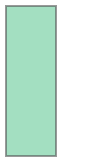

In [32]:
###     box(xmin,    ymin,    xmax,    ymax)
test = filtered_bboxes[-1]
# aoi = box(test[0], test[2], test[1], test[3]); aoi
aoi = box(-75, -100, -25, 50); aoi

In [33]:
ring_x = list(aoi.exterior.coords.xy[0])
ring_y = list(aoi.exterior.coords.xy[1])
# probably could make our own df for this easy example but we will use the built ins
poly_bounding_boxes = cuspatial.polygon_bounding_boxes([0], [0], ring_x[:-1], ring_y[:-1])
poly_bounding_boxes

,x_min,y_min,x_max,y_max
0,-75.0,-100.0,-25.0,50.0


In [34]:
poly_quad_pairs = cuspatial.join_quadtree_and_bounding_boxes(quadtree, poly_bounding_boxes, min_x, max_x, min_y, max_y, scale=scale, max_depth=max_depth)
poly_quad_pairs

,poly_offset,quad_offset
0,0,15
1,0,24
2,0,26
3,0,27
4,0,29
5,0,43
6,0,44
7,0,45
8,0,46
9,0,47


In [35]:
spatial_join_rslt = cuspatial.quadtree_point_in_polygon(poly_quad_pairs, quadtree, key_to_pt, df['x'], df['y'], [0], [0], ring_x[:-1], ring_y[:-1])
spatial_join_rslt

,point_index,polygon_index
0,0,4
1,0,5
2,0,6
3,0,7
4,0,8
...,...,...
444912,0,25851470
444913,0,25851724
444914,0,25851725
444915,0,25851726


In [36]:
rslt_df = df.iloc[key_to_pt.iloc[spatial_join_rslt.polygon_index].values]
rslt_df

,x,y,z,intensity,r,g,b
374097,-66.479,-89.862,-2.465,-1388,121,129,142
374098,-67.638,-91.719,-2.672,-1406,223,221,234
374099,-67.590,-91.750,-2.571,-1432,216,213,220
374100,-67.638,-91.720,-2.615,-1416,149,162,170
374101,-67.277,-91.230,-2.543,-1414,181,181,191
...,...,...,...,...,...,...,...
14197517,-25.154,17.878,-2.812,-1653,136,153,181
14197771,-25.002,18.574,-2.269,-1403,132,153,182
14197772,-25.010,18.639,-2.298,-1399,59,71,83
14197773,-25.051,18.630,-2.254,-1647,131,155,183


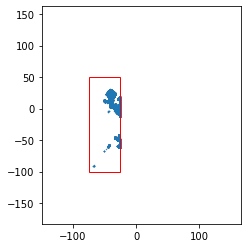

In [37]:
# plot a queried points
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(rslt_df['x'].to_array(), rslt_df['y'].to_array(), .2)
ax.set_xlim(min_x - 0.2 * w, max_x + 0.2 * w)
ax.set_ylim(min_y - 0.2 * h, max_y + 0.2 * h)

rect = patches.Rectangle((aoi.bounds[0], aoi.bounds[1]), aoi.bounds[2] - aoi.bounds[0], aoi.bounds[3] - aoi.bounds[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_aspect(1)

In [38]:
check_pts = cuspatial.points_in_spatial_window(aoi.bounds[0], aoi.bounds[2], aoi.bounds[1], aoi.bounds[3], df['x'], df['y'])
check_pts

,x,y
0,-44.285,-5.357
1,-44.757,-4.710
2,-66.582,-89.815
3,-66.531,-89.839
4,-66.427,-89.889
...,...,...
445819,-27.690,0.752
445820,-27.874,0.757
445821,-27.883,0.772
445822,-27.875,0.757


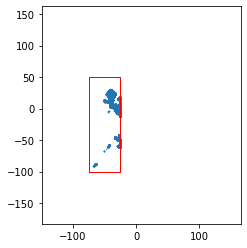

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(check_pts['x'].to_array(), check_pts['y'].to_array(), .2)
ax.set_xlim(min_x - 0.2 * w, max_x + 0.2 * w)
ax.set_ylim(min_y - 0.2 * h, max_y + 0.2 * h)

rect = patches.Rectangle((aoi.bounds[0], aoi.bounds[1]), aoi.bounds[2] - aoi.bounds[0], aoi.bounds[3] - aoi.bounds[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_aspect(1)